# Bonus Track Assignment #2:
## Implementing Liquid State Machines (LSMs)

### Bonus Track Assignment: Solving the Sunspot task

In [5]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error

---
# [Load requested outputs]

In [6]:
#errors = np.load('lsm_MAE.npy')
#print(f'\nTraining MAE = {errors[0]} \nValidation MAE = {errors[1]} \nTest MAE = {errors[2]}')

---

### The "Liquid" is a layer of interconnected Izhikevich neurons that takes in input our time series as an external applied current

to implement the liquid I used a tansposition into python of the provided MATLAB code available at:
https://drive.google.com/file/d/1GFb2UY97McTy9z0kMI-S8DYwatRYaT2z/view?usp=sharing


In [7]:
def modified_lsm(input, Ne, Ni, win_e, win_i, w_e, w_i):

    re = np.random.rand(Ne)
    ri = np.random.rand(Ni)
    a = np.concatenate([0.02 * np.ones(Ne), 0.02 + 0.08 * ri])
    b = np.concatenate([0.2 * np.ones(Ne), 0.25 - 0.05 * ri])
    c = np.concatenate([-65 + 15 * re ** 2, -65 * np.ones(Ni)])
    d = np.concatenate([8 - 6 * re ** 2, 2 * np.ones(Ni)])

    U = np.concatenate([win_e * np.ones(Ne), win_i * np.ones(Ni)])
    S = np.concatenate([w_e * np.random.rand(Ne + Ni, Ne), -w_i * np.random.rand(Ne + Ni, Ni)], axis=1)

    v = -65 * np.ones(Ne + Ni)    # Initial values of v
    u = b * v                     # Initial values of u
    firings = []                  # spike timings

    states = []  # here we construct the matrix of reservoir states

    for t in range(input.shape[0]):  # simulation of 1000 ms

        I = input[t] * U
        fired = np.where(v >= 30)[0]    # indices of spikes
        firings.append(np.concatenate([t + np.zeros(len(fired)).reshape(-1, 1), fired.reshape(-1, 1)], axis=1))
        v[fired] = c[fired]
        u[fired] = u[fired] + d[fired]

        I = I + np.sum(S[:, fired], axis=1)
        v = v + 0.5 * (0.04 * v ** 2 + 5 * v + 140 - u + I)    # step 0.5 ms
        v = v + 0.5 * (0.04 * v ** 2 + 5 * v + 140 - u + I)    # for numerical stability
        u = u + a * (b * v - u)

        states.append((v >= 30).astype(int))

    firings = np.concatenate(firings, axis=0)
    
    #plt.figure(figsize = (20,5))
    #plt.plot(firings[:, 0], firings[:, 1], '.')
    #plt.show()

    # in the end states is 1000 x number of time steps
    states = np.array(states).T
    return states

## Load the dataset and plot it

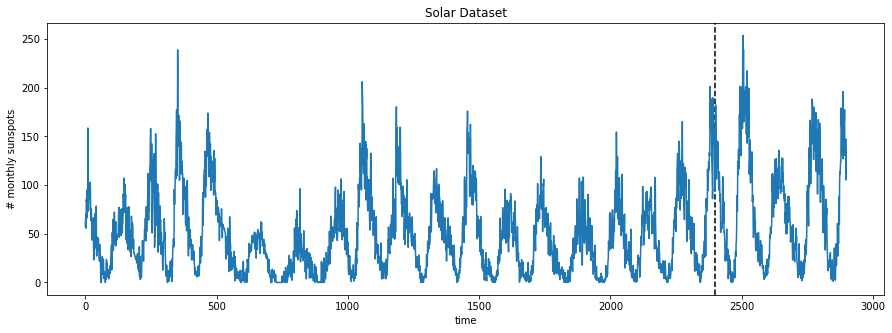

In [8]:
#import dataset
whole_dataset = np.loadtxt("solar_data.csv", delimiter=",")
x = whole_dataset[:-1] # input dataset
y = whole_dataset[1:] #target dataset

#split in train and test set
x_train = x[:2398]
y_train = y[:2398]
x_test = x[2398:]
y_test = y[2398:]

#plot the data
plt.figure(figsize = (15,5))
plt.title('Solar Dataset')
plt.xlabel('time')
plt.ylabel('# monthly sunspots')
plt.axvline(x = 2398, color = 'black', linestyle= '--')
plt.plot(whole_dataset)
plt.show()

## Model Selection
For model selection, we further split the train data into train and validation 

In [9]:
# we use the first 2000 timesteps for training and the remaining 398 for validation
X_train = x_train[:2000]
X_val = x_train[2000:]
Y_train = y_train[:2000]
Y_val = y_train[2000:]

print(len(X_train),len(X_val))

2000 398


### Define the hyperparameter search space to do model selection.
The hyperparameters are 6:
 - The total number of neurons
 - The percentage of excitatory neurons
 - The scaling of input connections (excitatory and inhibitory)
 - The scaling of recurrent connections (excitatory and inhibitory)

In [10]:
#total number of neurons
N = [100,200] 
#percentage of excitatory neurons
perc = [0.5,0.8,0.9] 
# scaling of input connections
win_e=[1,2.5,5] 
win_i=[1,2.5,5] 
# scaling of recurrent connections
w_e=[0.1,0.25,0.5] 
w_i=[0.1,0.5,1] 

#compute all the possible combinations
p = np.array(np.meshgrid(N, perc, win_e,win_i,w_e,w_i)).T.reshape(-1,6)

print(f'The search space is composed of {len(p)} combinations of hyperparameters')

The search space is composed of 486 combinations of hyperparameters


### Find optimal parameters, i.e. the ones that minimize validation MAE.

For each iteration we consider a certain combination of hyperparameters, we train the readout using pseudoinversion, and finally we compute the output of the LSM. Then we calculate the MAE on the validation set to address the quality of the model trained with the chosen set of hyperparameters.

We iterate for every combination of hyperparameters, in order to find the best one.

In [11]:
min_mae = 1e5 #very high value just to inizialize 
best = 0 #index to track the best iteration

for i in range(len(p)):
    Ne = int(p[i,0]*p[i,1])
    Ni = int(p[i,0] - Ne)
    win_e, win_i, w_e, w_i = p[i,2:]

    trainStates = modified_lsm(X_train, Ne, Ni, win_e, win_i, w_e, w_i)
    #readout weight matrix, computed using pseudoinversion
    Wout = np.dot(Y_train,np.linalg.pinv(trainStates))

    valStates = modified_lsm(X_val, Ne, Ni, win_e, win_i, w_e, w_i)
    #Output of the LSM for the validation states
    valOutput = np.dot(Wout, valStates)
    mae = mean_absolute_error(Y_val, valOutput)

    if mae < min_mae:
        min_mae = mae
        best = i

    print(f'iteration {i}, mae = {mae}, params: N={p[i,0]}, perc={p[i,1]}, win_e={p[i,2]}, win_i={p[i,3]}, w_e={p[i,4]}, w_i={p[i,5]}, best mae so far = {min_mae}')

best_params = p[best]
print(f'Finished model selection\nminimum mae = {min_mae} correspondig to \nbest params: N={best_params[0]}, perc={best_params[1]}, win_e={best_params[2]}, win_i={best_params[3]}, w_e={best_params[4]}, w_i={best_params[5]}')

#save the best hyperparameters found
np.save('lsm_params',best_params)

iteration 0, mae = 33.19591472126328, params: N=100.0, perc=0.5, win_e=1.0, win_i=1.0, w_e=0.1, w_i=0.1, best mae so far = 33.19591472126328
iteration 1, mae = 35.866808867615475, params: N=100.0, perc=0.8, win_e=1.0, win_i=1.0, w_e=0.1, w_i=0.1, best mae so far = 33.19591472126328
iteration 2, mae = 37.65690327266687, params: N=100.0, perc=0.9, win_e=1.0, win_i=1.0, w_e=0.1, w_i=0.1, best mae so far = 33.19591472126328
iteration 3, mae = 44.556897651732136, params: N=200.0, perc=0.5, win_e=1.0, win_i=1.0, w_e=0.1, w_i=0.1, best mae so far = 33.19591472126328
iteration 4, mae = 41.048667718901434, params: N=200.0, perc=0.8, win_e=1.0, win_i=1.0, w_e=0.1, w_i=0.1, best mae so far = 33.19591472126328
iteration 5, mae = 43.87146948182778, params: N=200.0, perc=0.9, win_e=1.0, win_i=1.0, w_e=0.1, w_i=0.1, best mae so far = 33.19591472126328
iteration 6, mae = 51.262098348614785, params: N=100.0, perc=0.5, win_e=2.5, win_i=1.0, w_e=0.1, w_i=0.1, best mae so far = 33.19591472126328
iteration

To load the best hyperparameters from file:

In [12]:
best_params = np.load('lsm_params.npy')

### Solve the regression task using the optimal parameters found
Now that we found the optimal hyperparameters, we reinstantiate the model and solve the regression task.

In [13]:
Ne = int(best_params[0]*best_params[1])
Ni = int(best_params[0] - Ne)

trainStates = modified_lsm(X_train, Ne, Ni, *(best_params[2:]))

Wout = np.dot(Y_train,np.linalg.pinv(trainStates))
trainOutput = np.dot(Wout, trainStates)
mae_train = mean_absolute_error(Y_train, trainOutput)

valStates = modified_lsm(X_val,Ne, Ni, *(best_params[2:]))
valOutput = np.dot(Wout, valStates)
mae_val = mean_absolute_error(Y_val, valOutput)

testStates = modified_lsm(x_test,Ne, Ni, *(best_params[2:]))
testOutput = np.dot(Wout, testStates)
mae_test = mean_absolute_error(y_test, testOutput)

### Make plots
Finally (for train, validation and test) we plot the reconstructed output, compared to the target data. 

We also calculate training, validation and test error (MAE) to have a quantitative measure of the quality of the LSM predictions.

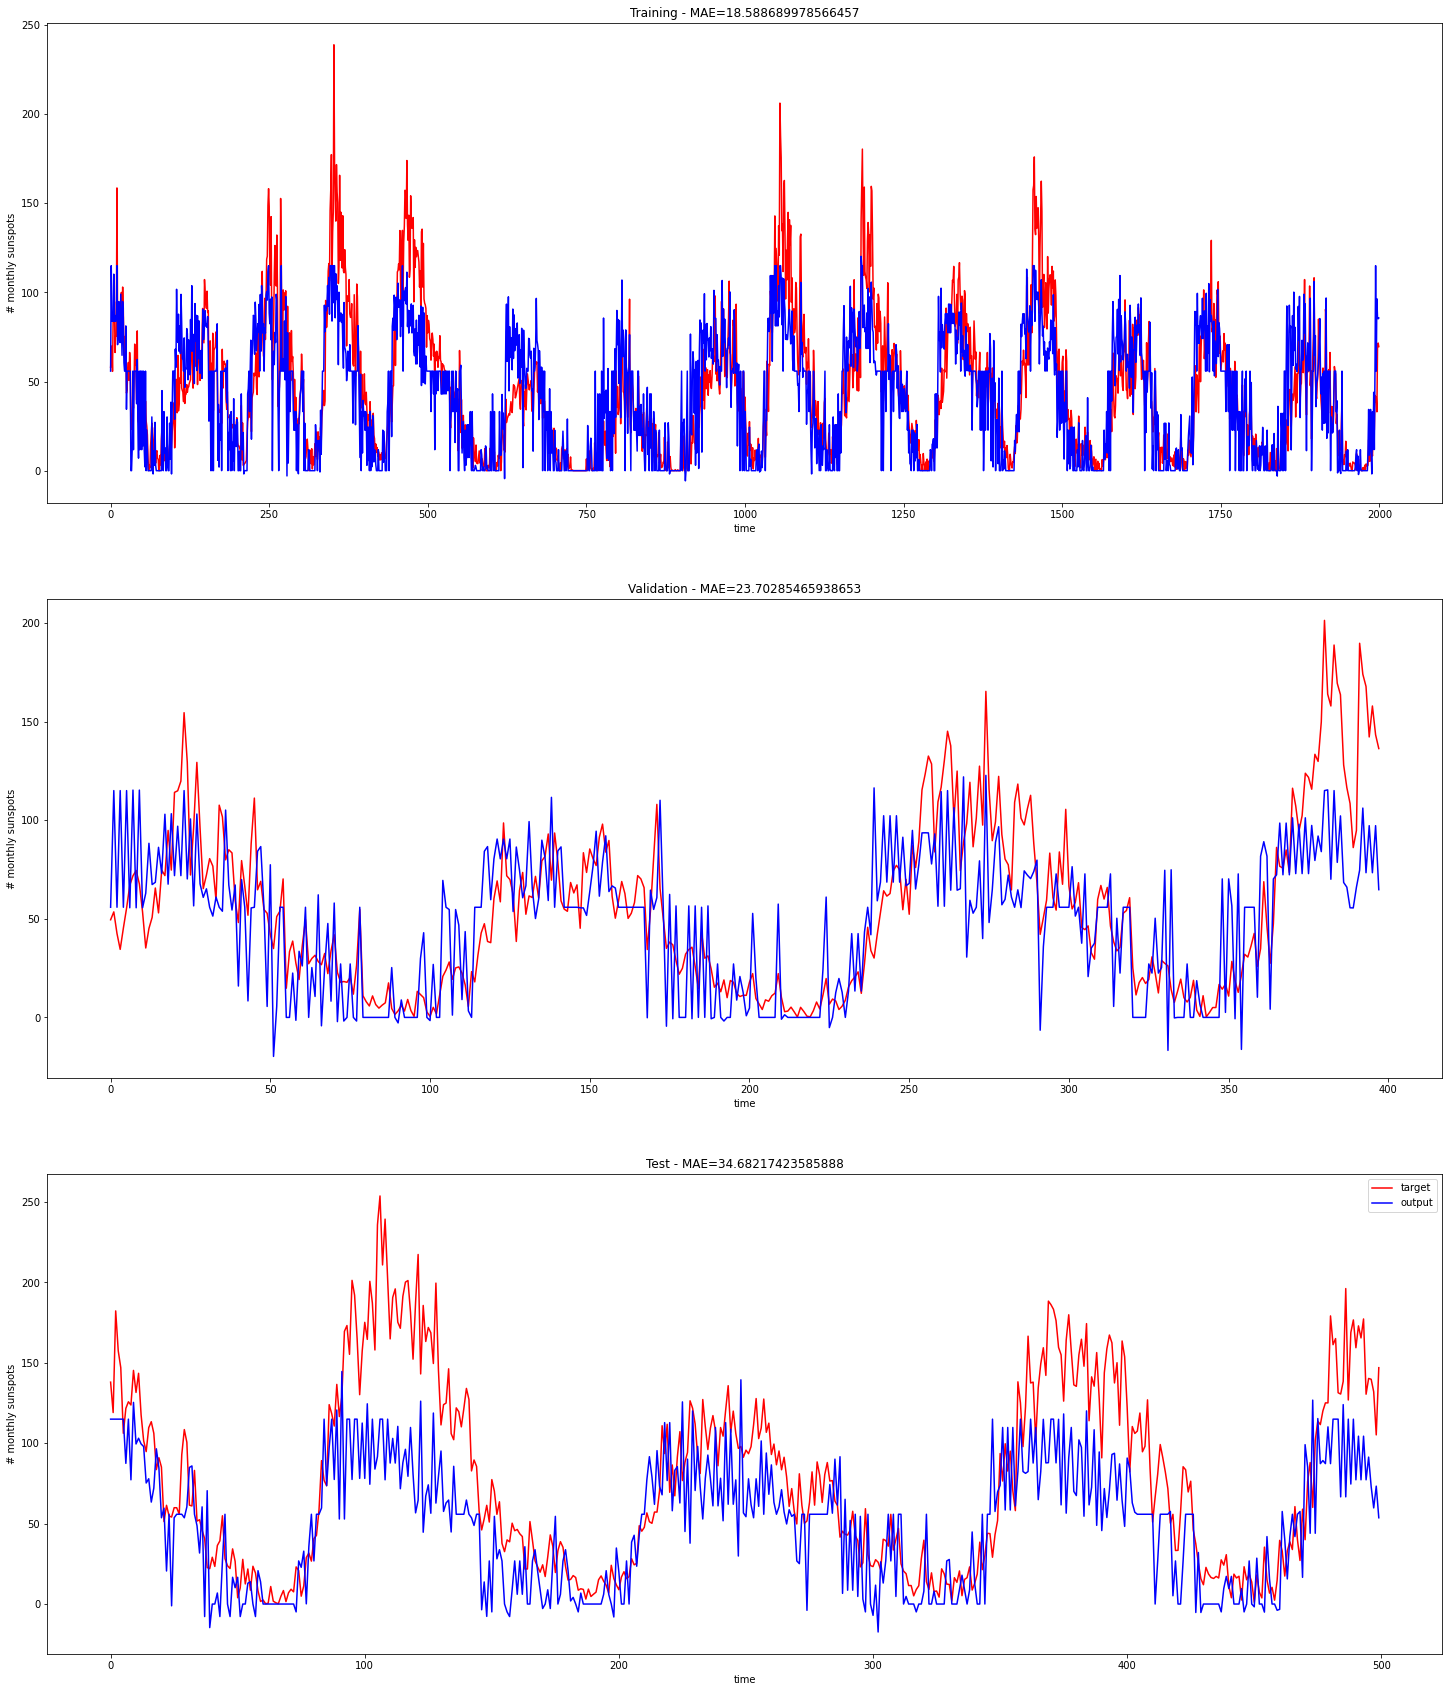

[18.588689978566457, 23.70285465938653, 34.68217423585888]


In [14]:
plt.figure(figsize = (25,30))
plt.subplot(311)
plt.title(f'Training - MAE={mae_train}')
plt.plot(X_train, color='red', label = 'target')
plt.plot(trainOutput, color = 'blue', label = 'output')
plt.xlabel('time')
plt.ylabel('# monthly sunspots')

plt.subplot(312)
plt.title(f'Validation - MAE={mae_val}')
plt.plot(X_val, color='red', label = 'target')
plt.plot(valOutput, color = 'blue', label = 'output')
plt.xlabel('time')
plt.ylabel('# monthly sunspots')

plt.subplot(313)
plt.title(f'Test - MAE={mae_test}')
plt.plot(y_test, color='red', label = 'target')
plt.plot(testOutput, color = 'blue', label = 'output')
plt.xlabel('time')
plt.ylabel('# monthly sunspots')
plt.legend()
plt.savefig(f"plots_bt2/Sunspot_target_vs_output.pdf")
plt.show()

#save training, validation and test errors.
errors = [mae_train, mae_val, mae_test]
print(errors)
np.save('lsm_MAE', errors)

To load saved training, validation and test errors:

In [15]:
#errors = np.load('lsm_MAE.npy')